In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ucimlrepo import fetch_ucirepo


In [12]:
def get_parkinsons_dataset():
    # fetch dataset 
    parkinsons = fetch_ucirepo(id=320) 
    
    # data (as pandas dataframes) 
    X = parkinsons.data.features 
    y = parkinsons.data.targets
    cols = X.columns
    
    return X, y, cols

In [13]:
X, y, cols = get_parkinsons_dataset()

In [14]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0


In [15]:
y

,G1,G2,G3
0,0,11,11
1,9,11,11
2,12,13,12
3,14,14,14
4,11,13,13
...,...,...,...
644,10,11,10
645,15,15,16
646,11,12,9
647,10,10,10


In [4]:
y.to_numpy().flatten().shape

(472,)

In [5]:
472*0.7

330.4

In [3]:
# read in all the files from the results folder
# datasource = ["function", "imodels", "imodels", "imodels", "openml", "imodels"]
# dataname = ["adult", "compas_two_year_clean", "diabetes", "diabetes_regr", "183", "california_housing"]
# seed = ["3", "2", "3", "3", "3", "3"]
# task = ["classification", "classification", "classification", "regression", "regression", "regression"]
# datasource = ["imodels", "imodels", "openml", "imodels"]
# dataname = ["diabetes_regr", "diabetes", "183", "compas_two_year_clean"]
# seed = ["3", "3", "3", "3"]
# task = ["regression", "classification", "regression", "classification"]
datasource = ["function"]
dataname = ["parkinsons"]
seed = ["1"]
task = ["regression"]
methods = ['shap', 'signed_normalized_l2_avg', 'signed_normalized_l2_noavg',
           'signed_nonnormalized_l2_avg', 'signed_nonnormalized_l2_noavg',
           'nonl2_avg', 'nonl2_noavg', 'l2_ranking', 'nonl2_ranking', 'baseline']
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
p_values = list(map(str, p_values))
values_results = {}
rankings_results = {}
task_results = {}
for i in range(len(dataname)):
    values_dict = {}
    rankings_dict = {}
    for method in methods:
        file = f"results/test_data/{datasource[i]}_{dataname[i]}_seed{seed[i]}_{method}_values.csv"
        values_dict[method] = pd.read_csv(file)
        for p_value in p_values:
            file = f"results/test_data/{datasource[i]}_{dataname[i]}_seed{seed[i]}_{method}_{p_value}_ranking.csv"
            rankings_dict[method + "_" + p_value] = pd.read_csv(file)
    values_results[datasource[i] + "_" + dataname[i]] = values_dict
    rankings_results[datasource[i] + "_" +dataname[i]] = rankings_dict
    task_results[datasource[i] + "_" + dataname[i]] = task[i]

In [6]:
r2_aucs = {}
for method in methods:
    aucs_per_seed = []
    for s in seed:
        aucs_per_seed.append(np.trapz(values_results["function" + "_" + "parkinsons"][method].loc[:, "R^2"])/values_results["function" + "_" + "parkinsons"][method].shape[0])
    aucs_per_seed = np.array(aucs_per_seed)
    r2_aucs[method] = aucs_per_seed.mean()
r2_aucs = pd.DataFrame(r2_aucs, index=[0]).T
r2_aucs.columns = ["R^2"]
r2_aucs

,R^2
shap,0.978722
signed_normalized_l2_avg,0.967216
signed_normalized_l2_noavg,0.965957
signed_nonnormalized_l2_avg,0.963637
signed_nonnormalized_l2_noavg,0.964239
nonl2_avg,0.972153
nonl2_noavg,0.974559
l2_ranking,0.786176
nonl2_ranking,0.768420
baseline,0.955294


## Results for Subgroup Experiments on Raw Feature Importance Scores

Results for dataset diabetes from datasource imodels.


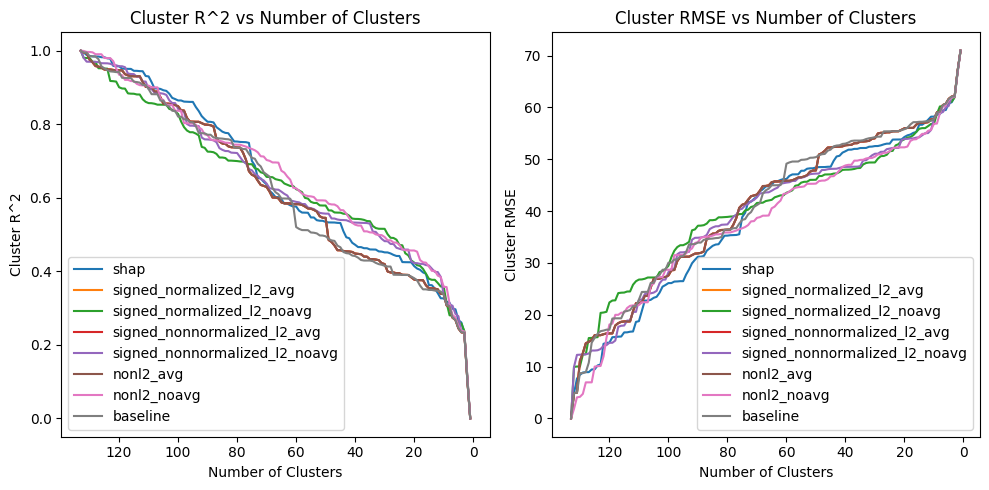

Results for dataset 183 from datasource openml.


KeyError: 'RMSE'

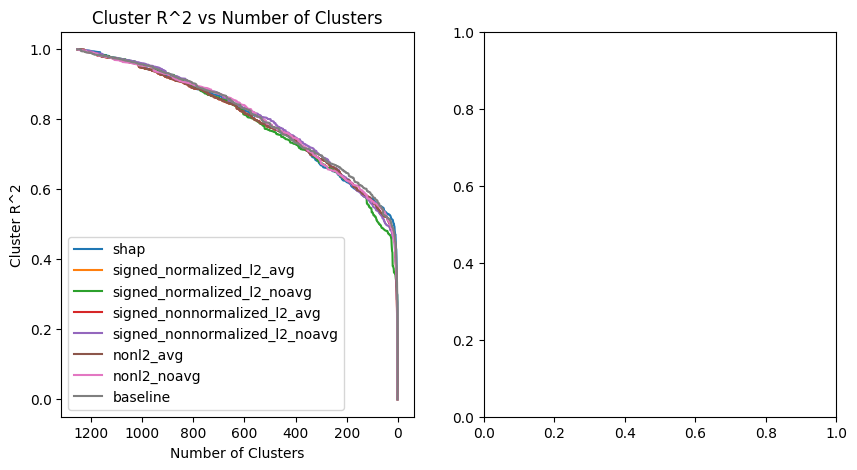

In [11]:
for key, values_dict in values_results.items():
    if task_results[key] == 'classification':
        metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
    else:
        metrics = ['R^2', 'RMSE']
    # print "Results for " + text of key after first underscore
    parts = key.split('_')
    print(f"Results for dataset {parts[1]} from datasource {parts[0]}.")
    # create new plot
    if task_results[key] == 'classification':
        height = 15
    else:
        height = 5
    fig, axes = plt.subplots(math.ceil(len(metrics)/2.0), 2, figsize=(10, height))
    axes = axes.flatten()
    plot_count = 0
    for metric in metrics:
        ax = axes[plot_count]
        # plt.figure()
        for method, df in values_dict.items():
            # plt.plot(df['nclust'], df[metric])
            ax.plot(df['nclust'], df[metric])
        ax.legend(list(values_dict.keys()))
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Cluster ' + metric)
        ax.set_title('Cluster ' + metric + ' vs Number of Clusters')
        ax.invert_xaxis()
        plot_count += 1
    plt.tight_layout()
    plt.show()

## Results for Subgroup Experiments on Feature Rankings

Results for dataset diabetes from datasource imodels.
Results for RBO Matrix with parameter p = 0.1.


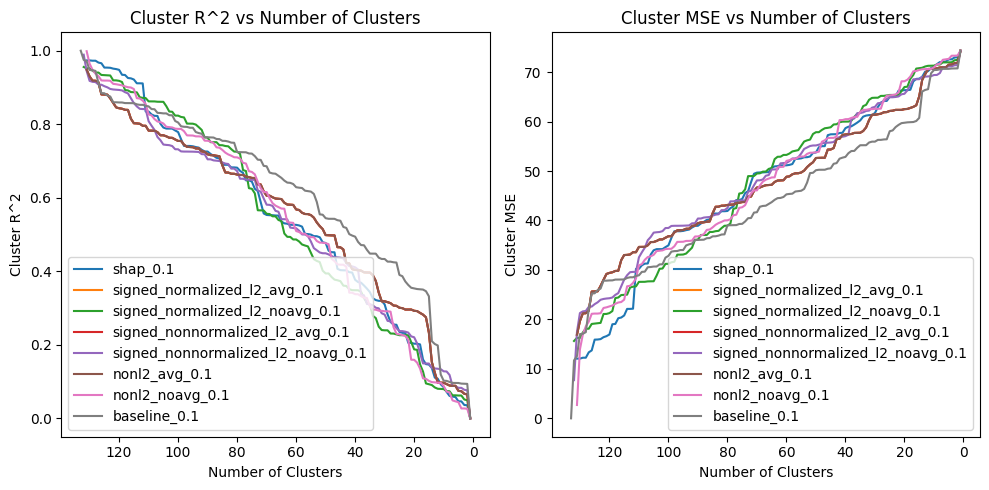

Results for RBO Matrix with parameter p = 0.3.


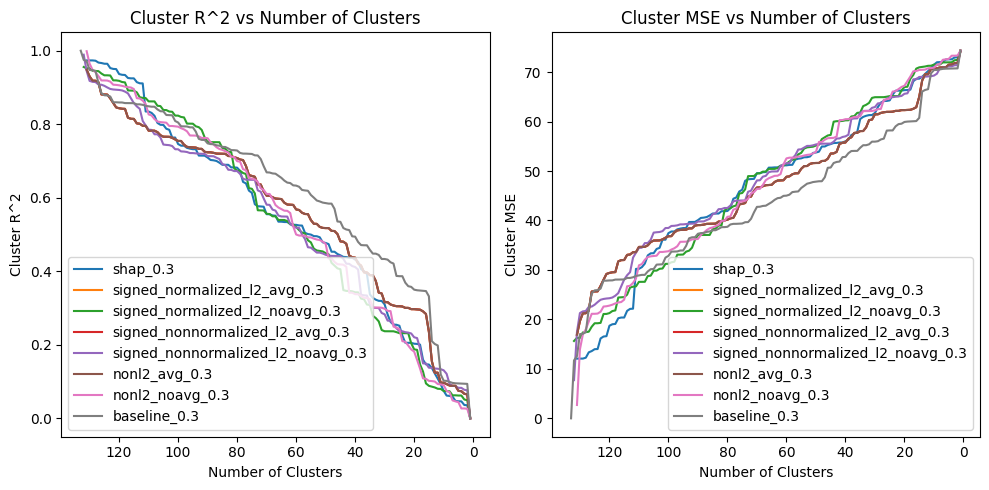

Results for RBO Matrix with parameter p = 0.5.


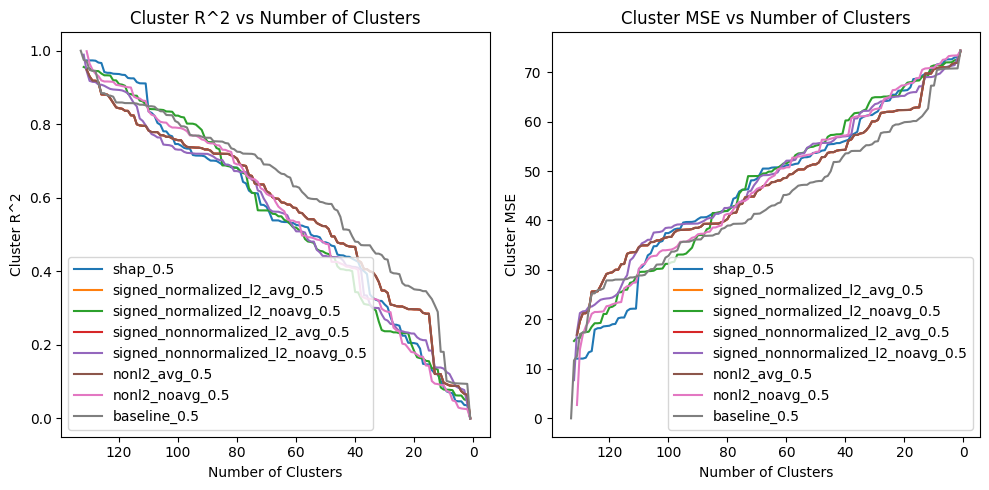

Results for RBO Matrix with parameter p = 0.7.


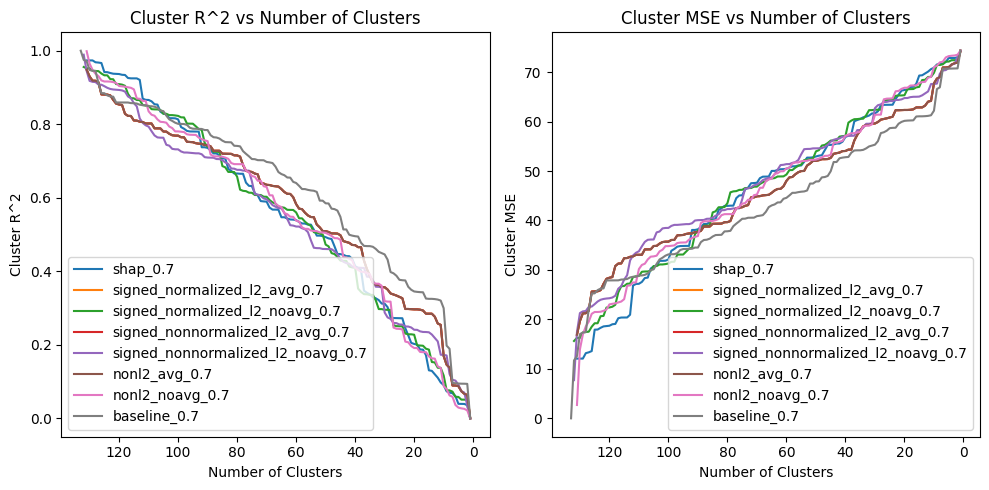

Results for RBO Matrix with parameter p = 0.9.


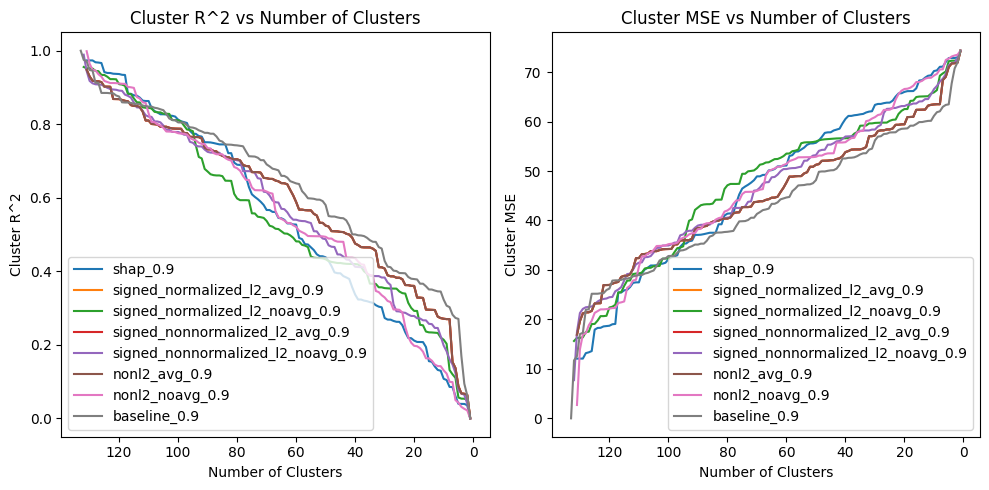

Results for dataset 183 from datasource openml.
Results for RBO Matrix with parameter p = 0.1.


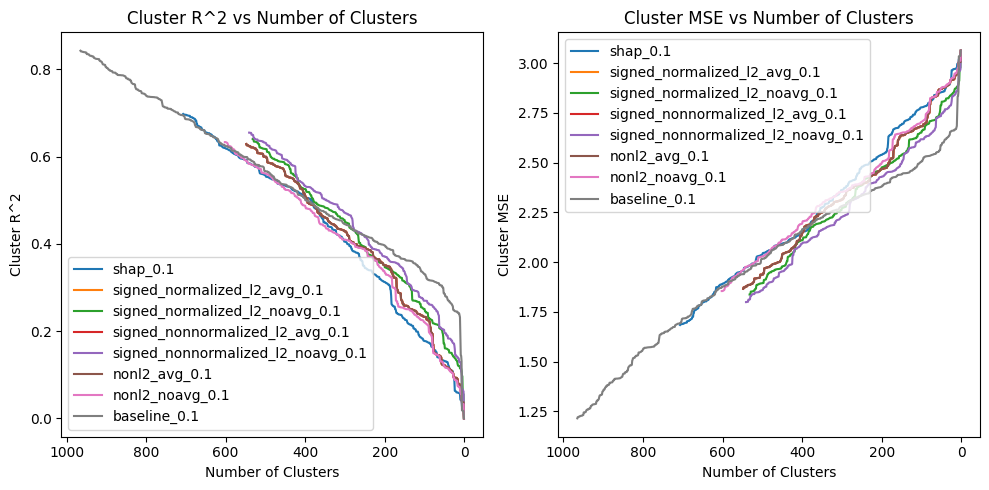

Results for RBO Matrix with parameter p = 0.3.


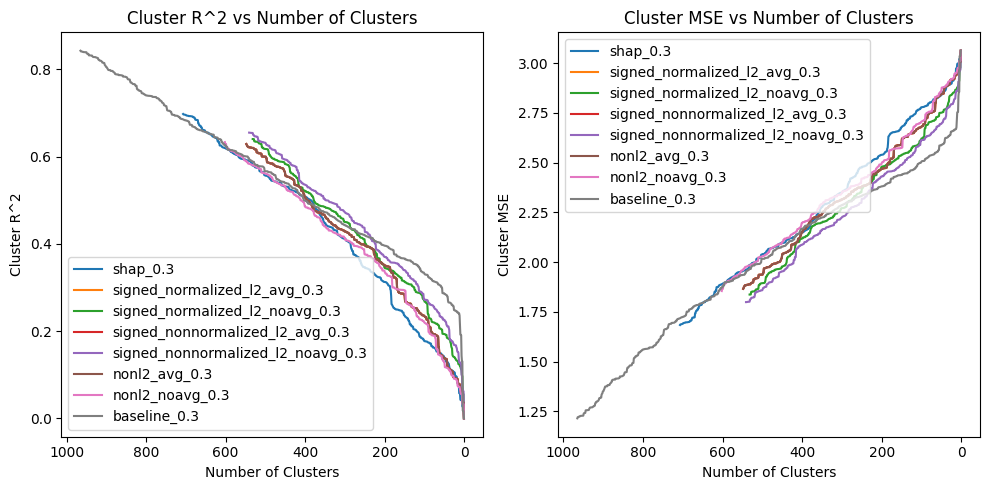

Results for RBO Matrix with parameter p = 0.5.


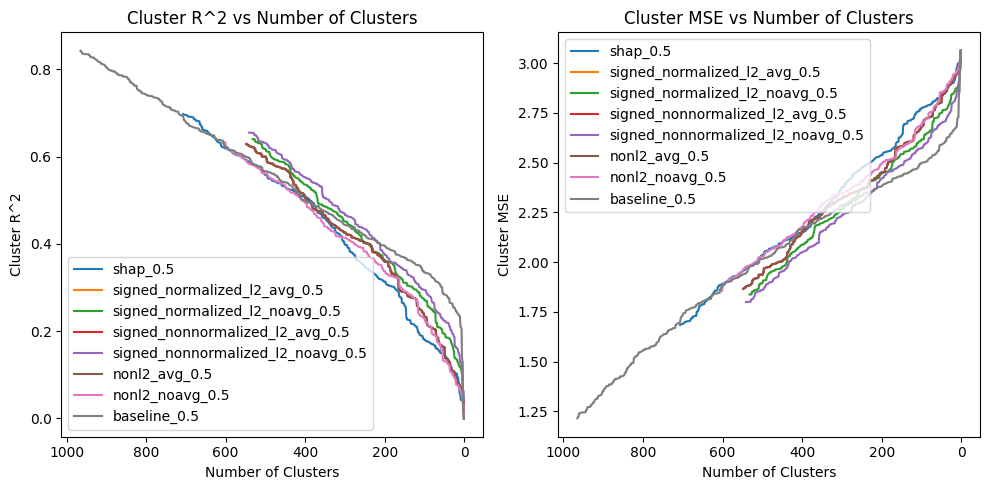

Results for RBO Matrix with parameter p = 0.7.


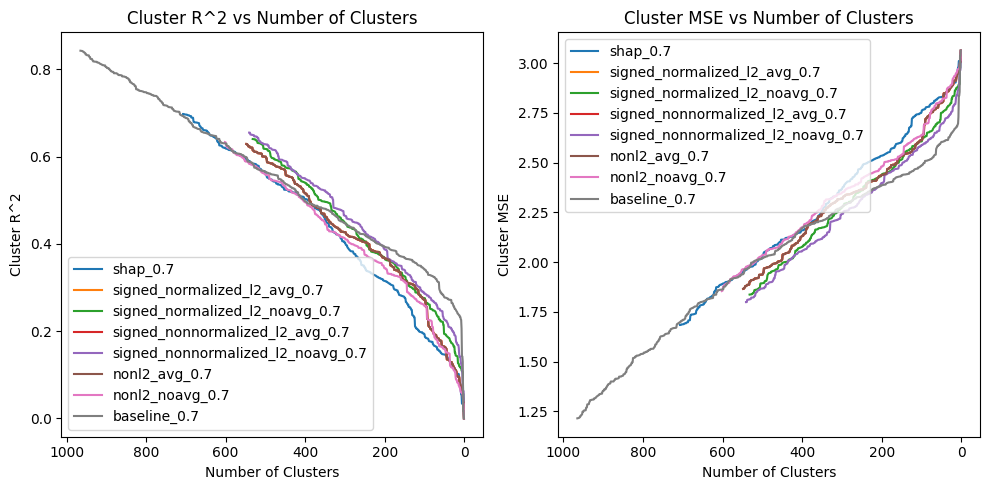

Results for RBO Matrix with parameter p = 0.9.


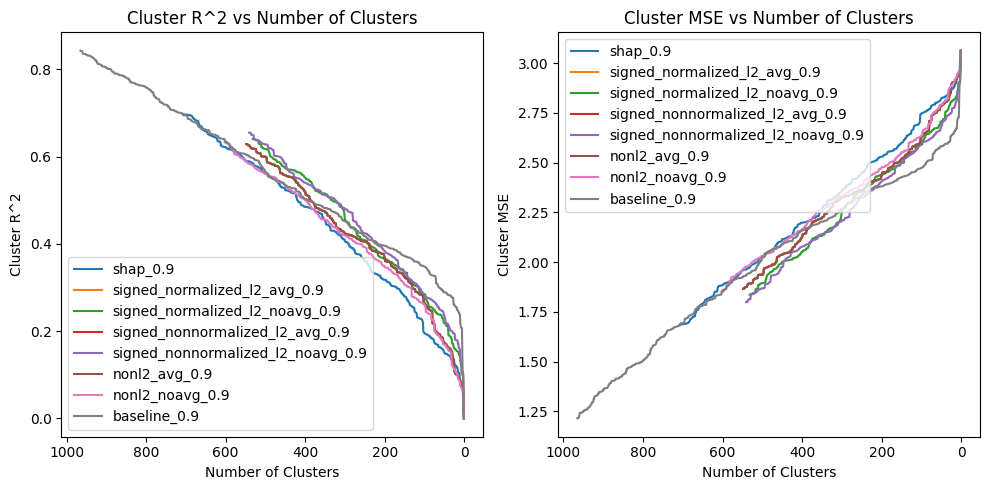

In [ ]:
for key, rankings_dict in rankings_results.items():
    if task_results[key] == 'classification':
        metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
    else:
        metrics = ['R^2', 'MSE']
    # print "Results for " + text of key after first underscore
    parts = key.split('_')
    print(f"Results for dataset {parts[1]} from datasource {parts[0]}.")
    for p_value in p_values:
        print(f"Results for RBO Matrix with parameter p = {p_value}.")
        # create new plot
        if task_results[key] == 'classification':
            height = 15
        else:
            height = 5
        fig, axes = plt.subplots(math.ceil(len(metrics)/2.0), 2, figsize=(10, height))
        axes = axes.flatten()
        plot_count = 0
        for metric in metrics:
            # create new plot
            ax = axes[plot_count]
            method_list = []
            for method, df in rankings_dict.items():
                if method.endswith(p_value):
                    ax.plot(df['nclust'], df[metric])
                    method_list.append(method)
            ax.legend(method_list)
            ax.set_xlabel('Number of Clusters')
            ax.set_ylabel('Cluster ' + metric)
            ax.set_title('Cluster ' + metric + ' vs Number of Clusters')
            ax.invert_xaxis()
            plot_count += 1
        plt.tight_layout()
        plt.show()